In [2]:
import os
import pandas as pd
import numpy as np
os.chdir('/Users/younghun/Desktop/gitrepo/data')

In [26]:
card_df = pd.read_csv('creditcard.csv', encoding='utf-8')
card_df.shape

(284807, 31)

In [6]:
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
# 원본 데이터프레임을 복사하고 필요없는 Time칼럼 없애는 함수 정의해주기
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

# 위에서 사전적으로 가공한 데이터프레임을 train, test 데이터로 split하기
def split_train_test(df):
    df_copy = get_preprocessed_df(df)
    
    x_features = df_copy.iloc[:, :-1]
    y_labels = df_copy.iloc[:, -1]
    
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels,
                                                       test_size=0.2,
                                                       random_state=42)
    return x_train, x_test, y_train, y_test

In [8]:
x_train, x_test, y_train, y_test = split_train_test(card_df)

In [11]:
print("학습 데이터 레이블 분포 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print("검증 데이터 레이블 분포 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

# 학습, 검증 데이터 각각 레이블 분포 비율은 맞춰줌

학습 데이터 레이블 분포 비율
0    99.827075
1     0.172925
Name: Class, dtype: float64
검증 데이터 레이블 분포 비율
0    99.827955
1     0.172045
Name: Class, dtype: float64


In [12]:
# classification metric 얻는 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 - pred_proba 인자 넣어주는거 인지!
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [13]:
# Logistic Regression 적용해보기
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)

lr_pred = lr_clf.predict(x_test)
lr_pred_proba = lr_clf.predict_proba(x_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[56854    10]
 [   46    52]]
정확도: 0.9990, 정밀도: 0.8387, 재현율: 0.5306,    F1: 0.6500, AUC:0.9529


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [65]:
# 여러 모델을 다룰 것이므로 모델을 학습시키는 함수 개별적으로 정의
def train_model(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)


In [17]:
# LightGBM 모델링하기
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64)
train_model(lgbm_clf, x_train, x_test, y_train, y_test)

오차 행렬
[[56796    68]
 [   93     5]]
정확도: 0.9972, 정밀도: 0.0685, 재현율: 0.0510,    F1: 0.0585, AUC:0.5249
None


# 중요 데이터 분포도 변환하는 feature engineering

<AxesSubplot:xlabel='Amount'>

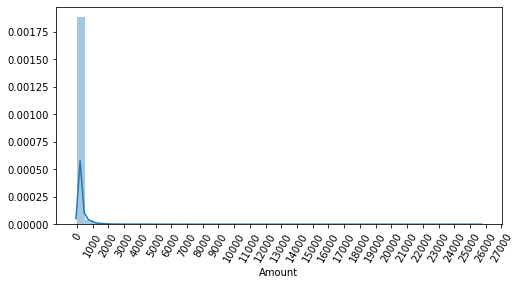

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [30]:
# 분포도를 변화시키기 위해서 StandardScaler 적용해서 학습시켜보기
from sklearn.preprocessing import StandardScaler

def split_train_test(df):
    df_copy = get_preprocessed_df(df)
    
    x_features = df_copy.iloc[:, :-1]
    y_labels = df_copy.iloc[:, -1]
    
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels,
                                                       test_size=0.2,
                                                       random_state=42)
    return x_train, x_test, y_train, y_test

def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    # dataframe의 values를 2차원 array로 변형해준 후 scaler적용해야함
    scaled_amount = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # insert문법으로 데이터프레임도 리스트처럼 넣을 수 있음
    # df.insert(칼럼순서위치, 칼럼이름, 칼럼값)
    df_copy.insert(0, 'Amount_scaled', scaled_amount)
    
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [31]:
x_train, x_test, y_train, y_test = split_train_test(card_df)

In [32]:
print("로지스틱 회귀 모델링 결괴")
lr_clf = LogisticRegression()
train_model(lr_clf, x_train, x_test, y_train, y_test)
print()
print("LightGBM 모델링 결과")
lgbm_clf = LGBMClassifier()
train_model(lgbm_clf, x_train, x_test, y_train, y_test)

로지스틱 회귀 모델링 결괴
오차 행렬
[[56855     9]
 [   41    57]]
정확도: 0.9991, 정밀도: 0.8636, 재현율: 0.5816,    F1: 0.6951, AUC:0.9762
None

LightGBM 모델링 결과
오차 행렬
[[56678   186]
 [   48    50]]
정확도: 0.9959, 정밀도: 0.2119, 재현율: 0.5102,    F1: 0.2994, AUC:0.6863
None


In [35]:
# Amount에 log변환을 취해서 분포도 변환시킨후 학습시키기
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_log', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [36]:
x_train, x_test, y_train, y_test = split_train_test(card_df)

In [37]:
print("로지스틱 회귀 모델링 결괴")
lr_clf = LogisticRegression()
train_model(lr_clf, x_train, x_test, y_train, y_test)
print()
print("LightGBM 모델링 결과")
lgbm_clf = LGBMClassifier()
train_model(lgbm_clf, x_train, x_test, y_train, y_test)

로지스틱 회귀 모델링 결괴
오차 행렬
[[56855     9]
 [   41    57]]
정확도: 0.9991, 정밀도: 0.8636, 재현율: 0.5816,    F1: 0.6951, AUC:0.9765
None

LightGBM 모델링 결과
오차 행렬
[[56784    80]
 [   94     4]]
정확도: 0.9969, 정밀도: 0.0476, 재현율: 0.0408,    F1: 0.0440, AUC:0.4919
None


<AxesSubplot:>

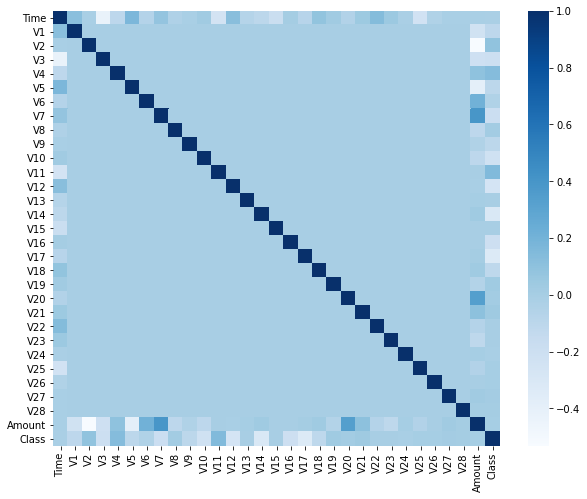

In [38]:
# 이상치 제거후 모델 학습 평가해보기
# 우선 class와 상관관계가 높은 변수를 기준으로 이상치를 제거하자
# 그러기 위해서 상관관계 살펴보기
plt.figure(figsize=(10,8))

corr = card_df.corr()
sns.heatmap(corr, cmap='Blues')

In [41]:
# V11이 가장 상관관계가 높으므로 해당 변수의 이상치를 제거해보자.

# weight값은 이상치에 포함되는 범위 결정할 때 곱해주는 계수값
def get_outlier(df, column, weight=1.5):
    # 사기에 해당하는 데이터들 중 해당 변수에 해당하는 값들만 출력
    fraud = df[df['Class'] ==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고 1.5를 곱해서 이상치 포함시킬 범위 정의
    iqr = quantile_75 - quantile_25
    iqr_w = iqr * weight
    lowest = quantile_25 - iqr_w
    highest = quantile_75 + iqr_w
    
    outlier_idx = fraud[(fraud < lowest) | (fraud > highest)].index
    
    return outlier_idx

In [43]:
outlier_idx = get_outlier(card_df, 'V11')
print(outlier_idx)

Int64Index([8296, 8335, 8615, 9035, 9179, 9252, 9487, 9509, 10568, 10801], dtype='int64')


In [44]:
# 로그변환 후 이상치 제거해주는 기능 추가
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_log', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    outlier_idx = get_outlier(card_df, 'V11')
    df_copy.drop(outlier_idx, axis=0, inplace=True)
    
    return df_copy

In [46]:
x_train, x_test, y_train, y_test = split_train_test(card_df)

In [47]:
print("로지스틱 회귀 모델링 결괴")
lr_clf = LogisticRegression()
train_model(lr_clf, x_train, x_test, y_train, y_test)
print()
print("LightGBM 모델링 결과")
lgbm_clf = LGBMClassifier()
train_model(lgbm_clf, x_train, x_test, y_train, y_test)

로지스틱 회귀 모델링 결괴
오차 행렬
[[56859     7]
 [   44    50]]
정확도: 0.9991, 정밀도: 0.8772, 재현율: 0.5319,    F1: 0.6623, AUC:0.9850
None

LightGBM 모델링 결과
오차 행렬
[[56803    63]
 [   32    62]]
정확도: 0.9983, 정밀도: 0.4960, 재현율: 0.6596,    F1: 0.5662, AUC:0.8594
None


In [49]:
# SMOTE(KNN에 기반한 오버샘플링) 적용 후 모델 학습
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# train 데이터에서 오버샘플링 시키기
x_train_over, y_train_over = smote.fit_sample(x_train, y_train)

# 오버샘플링 적용 후 데이터 레이블 개수 살펴보기
print('오버샘플링 전 :', x_train.shape, y_train.shape)
print()
print('오버샘플링 후 :', x_train_over.shape, y_train_over.shape)

print('오버샘플링 후 레이블 분포 :\n', pd.Series(y_train_over).value_counts())

오버샘플링 전 : (227837, 29) (227837,)

오버샘플링 후 : (454898, 29) (454898,)
오버샘플링 후 레이블 분포 :
 1    227449
0    227449
Name: Class, dtype: int64


In [50]:
lr_clf = LogisticRegression()
train_model(lr_clf, x_train_over, x_test, y_train_over, y_test)

오차 행렬
[[55302  1564]
 [    7    87]]
정확도: 0.9724, 정밀도: 0.0527, 재현율: 0.9255,    F1: 0.0997, AUC:0.9835
None


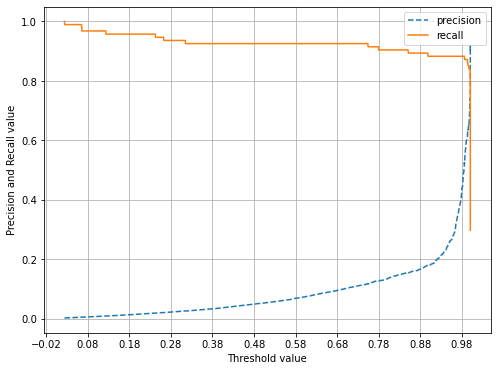

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(x_test)[:,1])

In [66]:
# boost_from_average는 디폴트값이 True인데 클래스 불균형이 매우 심할때
# True로 하면 재현율이 현저하게 떨어지는 모습을 보인다
# 따라서 클래스불균형이 매우 심할 때는 False값으로 바꾸어주자
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,
                         n_jobs=-1, boost_from_average=False)
train_model(lgbm_clf, x_train_over, x_test, y_train_over, y_test)

오차 행렬
[[56852    14]
 [   14    80]]
정확도: 0.9995, 정밀도: 0.8511, 재현율: 0.8511,    F1: 0.8511, AUC:0.9847
